In [1]:
''' MAIN
Load DESOM Class. It's here instead of being loaded for ease of debugging and developing DESOM-2 '''

from time import time
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.table import Table, vstack, Column

import tensorflow as tf
from keras.models import Model, load_model
from keras import optimizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from SOM import SOMLayer
from desom2_architectures_logging import DESOM
from tqdm import tqdm


Using TensorFlow backend.


In [2]:
''' MAIN | LOAD PRETRAINED MODEL
Load a model from a previous training session.
'''

def load_desom_trained(map_size, input_dims, model_path, latent):
    # this defines the architecture of DESOM-2 before loading weights.
    inner_som = DESOM(input_dims = input_dims, map_size = map_size, latent_dims = latent)
    inner_som.initialize()
    inner_som.load_weights(model_path)
    return inner_som

# ------ Model Parameters ------
LATENT_WIDTH = 128
D1_map_size = (15, 15)
D1_num_nodes = D1_map_size[0]*D1_map_size[1]
DATE, map_size = 'sep9a', (10,10)
num_nodes = map_size[0] * map_size[1]

model_name = '{}/DESOM_model_final_{}.h5'.format(DATE,LATENT_WIDTH)
folder='results/som2_testing/'

# ------- Load Model ----------
som = load_desom_trained(map_size, (D1_map_size[0], D1_map_size[1], 1) , model_path=folder+model_name, latent=LATENT_WIDTH)


cnn final (16 filter) 


In [3]:
''' MAIN
load FPs, clean up, reshape
'''

# ------ LOAD DATA --------
FP_table = Table.read('RF_fingerprint_sep9a.fits')

X_data = FP_table['train_fp'] + FP_table['test_fp']

# ----------- CLIP TO CLEAN UP FPS ----------
# clips each node to 99 percentile (helps remove massively oversampled galaxies)
percentile_vector = np.zeros(D1_num_nodes)
for i in range(D1_num_nodes):
    distribution = X_data[:,i]
    percentile_vector[i] = np.percentile(distribution, 99.9)

new_FPs = np.zeros((len(X_data),D1_num_nodes))
for i in range(D1_num_nodes):
    new_FPs[:,i] = np.clip(X_data[:,i],0,percentile_vector[i])

# ----------------- NORMALIZE ALONG NODE ------
z2_scaler = MinMaxScaler().fit(new_FPs) # unsaved
z2_data = z2_scaler.transform(new_FPs)

# ---------------- NORMALIZE ALONG FP ---------
z3_data = MinMaxScaler().fit_transform(z2_data.T).T

# ------------- Reshape -----------
X_data = z3_data.reshape(-1,D1_map_size[0], D1_map_size[1], 1)

# ------------- SPLIT ----------
# ----- set seed to be same as during training -----
np.random.seed(1)
tf.random.set_seed(1)
X_train, X_test = train_test_split(X_data, train_size=0.9)

print('fingerprints normalized')

fingerprints normalized


In [4]:

# ------ CALCULATE BMU FOR EACH GALAXY ------
best_node = som.predict(X_data)
FP_table['bmu'] = best_node


# ------ GENERATE HEIGHTMAP -------
heightmap_test = np.zeros(num_nodes)
for bmu in range(num_nodes):
    bmu_mask = (FP_table['bmu'] == bmu)
    test_mask = (FP_table[bmu_mask]['Testing_set'] == True)
    heightmap_test[bmu] = len(FP_table[bmu_mask][test_mask]['bmu'])
    
heightmap_train = np.zeros(num_nodes)
for bmu in range(num_nodes):
    bmu_mask = (FP_table['bmu'] == bmu)
    train_mask = (FP_table[bmu_mask]['Training_set'] == True)
    heightmap_train[bmu] = len(FP_table[bmu_mask][train_mask]['bmu'])


d2 heightmap
number training set: 3688.0
number testing set:  921.0


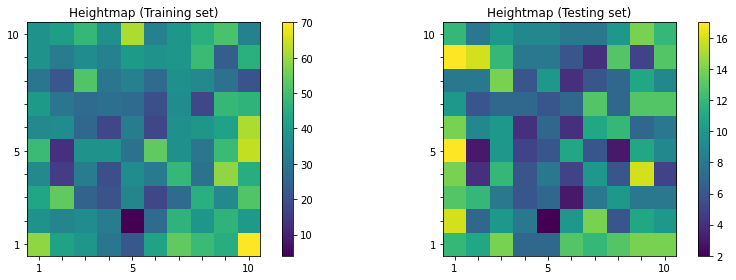

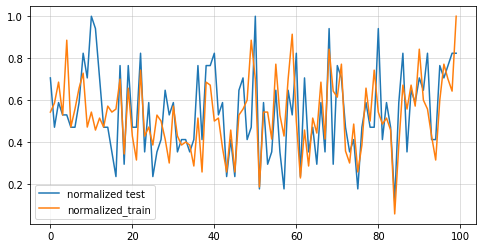

In [5]:
# MAINLINE
# the heightmap of DESOM 2

fig,ax = plt.subplots(1,2,figsize=(12,4))
    
panel = ax[0].imshow(heightmap_train.reshape(map_size))
fig.colorbar(panel,ax=ax[0])
ax[0].set_title('Heightmap (Training set)')

panel = ax[1].imshow(heightmap_test.reshape(map_size))
fig.colorbar(panel,ax=ax[1])
ax[1].set_title('Heightmap (Testing set)')

def fix_ticks(arg_ax):
    arg_ax.set_xticks(range(10))
    arg_ax.set_xticklabels([1,'','','',5,'','','','',10])
    arg_ax.set_yticks(range(10))
    arg_ax.set_yticklabels([10,'','','','',5,'','','',1])
fix_ticks(ax[0])
fix_ticks(ax[1])

plt.tight_layout()
print('d2 heightmap')


plt.figure(figsize=(8,4))
plt.plot(heightmap_test/heightmap_test.max(), label='normalized test')
plt.plot(heightmap_train/heightmap_train.max(), label='normalized_train')
plt.grid(alpha=0.5)
plt.legend()


print('number training set:',heightmap_train.sum())
print('number testing set: ',heightmap_test.sum())

(-0.5, 1.5, 255.5, -0.5)

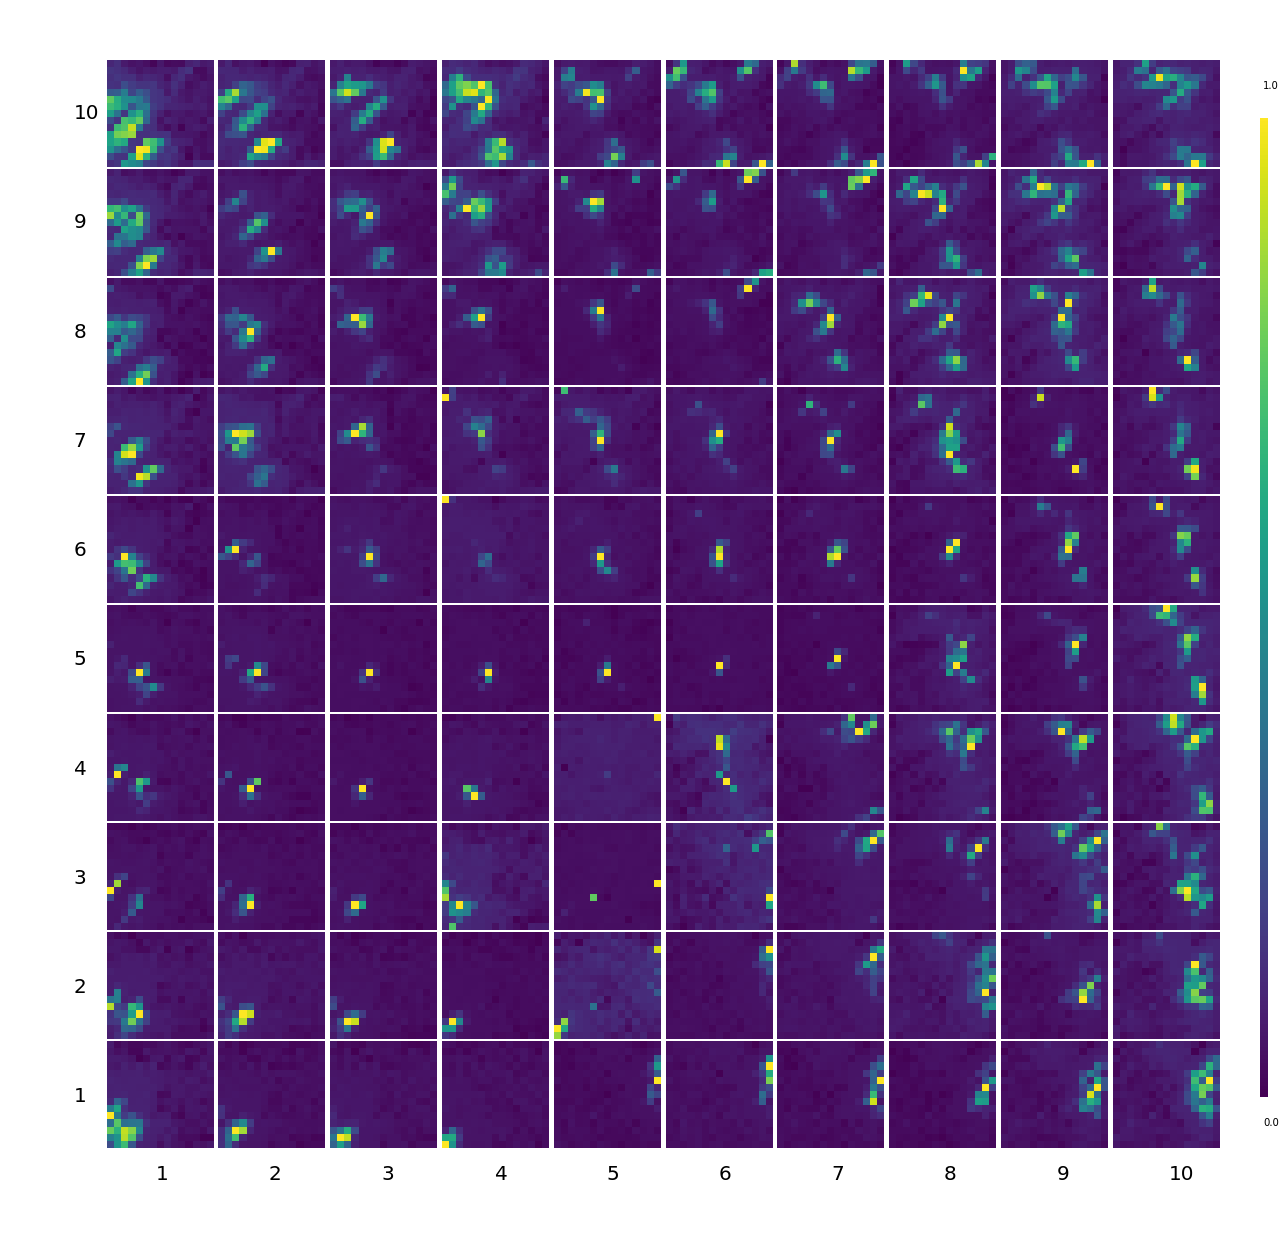

In [6]:
'''PLOT
Visualize prototypes from DESOM-2 (prototypical galaxies) '''


decoded_prototypes = som.decode(som.prototypes)


fig, ax = plt.subplots(map_size[0], map_size[1], figsize=(20,20))

for k in range(num_nodes):
    x = decoded_prototypes[k]
    ax[k // map_size[1]][k % map_size[1]].imshow(x.reshape(D1_map_size)), #cmap='Blues'
    ax[k // map_size[1]][k % map_size[1]].axis('off')
plt.subplots_adjust(hspace=0.02, wspace=0.02)

# ylabels
x_offset = (0.057,0.045)
x_step = 0.0872
for i in range(1,11):
    ax[0,0].annotate(i,
                xy=(x_offset[0], x_offset[1]+x_step*i), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize=20)

# xlabels  # left, from bottom
y_offset = (0.034,0.07)
y_step = 0.0875
for i in range(1,11):
    ax[0,0].annotate(i,
                xy=(y_offset[0]+y_step*i, y_offset[1]), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize=20)

    
# ----- COLOUR BAR ------
gradient=(np.linspace(0,1,256))
gradient = np.vstack((gradient, gradient))

# left, bottom, weight, height
caxleft=plt.axes([0.94, 0.14, 0, 0])
caxleft.text(0,0,'0.0',horizontalalignment='right')
caxleft.axis('off')
#
caxright=plt.axes([0.94, 0.86, 0, 0])
caxright.text(0,0,'1.0',horizontalalignment='right')
caxright.axis('off')
#
cax1=plt.axes([0.63, 0.16, 0.6, 0.68])
cax1.imshow(gradient.T, cmap='viridis_r')
cax1.axis('off')


In [7]:
#### MAIN LINE
# add morphology into this FP table

morph_table = Table.read('gal_morph.fits')
morph_table.colnames

morph_list = list()
for i in tqdm(range(len(FP_table))):
    manga_mask = (morph_table['mangaID'] == FP_table['mangaID'][i])
    morph_list.append(morph_table[manga_mask]['type'][0])
    
FP_table['morph'] = np.array(morph_list)
FP_table.colnames


100%|██████████| 4609/4609 [00:00<00:00, 5760.20it/s]


['mangaID',
 'train_fp',
 'test_fp',
 'unused_fp',
 'av_age',
 'Training_set',
 'Testing_set',
 'bmu',
 'morph',
 'sersic_n',
 'plateifu',
 'b_over_a']

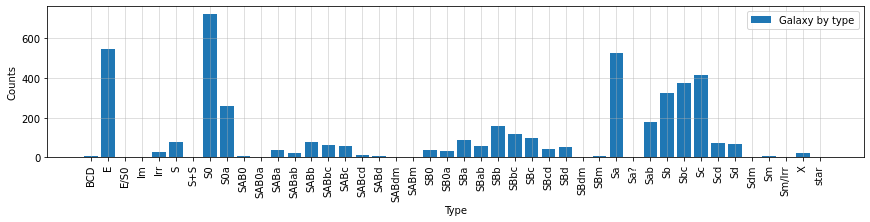

In [8]:
#############
# plot galaxy types
possible_types = np.unique(FP_table['morph'])

plt.figure(figsize=(12,3))
bar_y = np.zeros(possible_types.shape[0])
for i,k in enumerate(possible_types): #for each type of galaxy
    mask = (FP_table['morph'] == k)
    bar_y[i] = mask.sum()
    
plt.bar(np.arange(possible_types.shape[0]), bar_y)
plt.xticks(np.arange(possible_types.shape[0]), possible_types, rotation=90)
plt.tight_layout()
plt.xlabel('Type')
plt.ylabel('Counts')
plt.legend(['Galaxy by type'])
plt.grid(alpha=0.5)


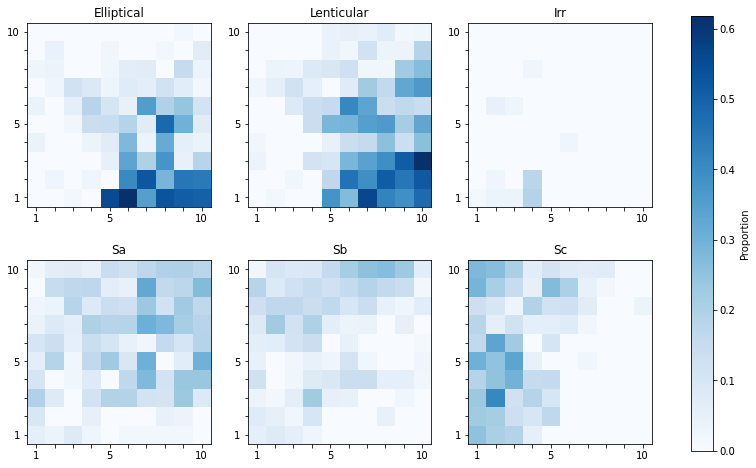

In [9]:
# proportion 

heightmap=np.zeros(num_nodes)
for bmu in range(num_nodes):
    masked=(FP_table['bmu'] == bmu)
    heightmap[bmu] = len(FP_table['bmu'][masked])

def proportion_plot(morphology):
    morph_mask = (FP_table['morph']==morphology)
    temp_map = np.zeros(num_nodes)
    for i in range(num_nodes):
        bmu_mask = (FP_table[morph_mask]['bmu']==i)
        temp_map[i] = len(FP_table[morph_mask][bmu_mask])/heightmap[i]
    return temp_map.reshape(map_size)

panels=list()

fig,ax=plt.subplots(2,3,figsize=(14,8))
panels.append(ax[0][0].imshow(proportion_plot('E'),cmap='Blues'))
ax[0][0].set_title('Elliptical')
fix_ticks(ax[0,0])

panels.append(ax[0][1].imshow(proportion_plot('S0'),cmap='Blues'))
ax[0][1].set_title('Lenticular')
fix_ticks(ax[0,1])

panels.append(ax[0][2].imshow(proportion_plot('Irr'),cmap='Blues'))
ax[0][2].set_title('Irr')
fix_ticks(ax[0,2])

panels.append(ax[1][0].imshow(proportion_plot('Sa'),cmap='Blues'))
ax[1][0].set_title('Sa')
fix_ticks(ax[1,0])

panels.append(ax[1][1].imshow(proportion_plot('Sb'),cmap='Blues'))
ax[1][1].set_title('Sb')
fix_ticks(ax[1,1])
      
panels.append(ax[1][2].imshow(proportion_plot('Sc'),cmap='Blues'))
ax[1][2].set_title('Sc')
fix_ticks(ax[1,2])

vmin = min(image.get_array().min() for image in panels)
vmax = max(image.get_array().max() for image in panels)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in panels:
    im.set_norm(norm)

cbar = fig.colorbar(panels[0], ax=ax, orientation='vertical', aspect=20)
cbar.set_label('Proportion')#,rotation=0)


In [10]:
# MAINLINE
# add new columns to table

# to get sersic values, load the original data, match mangaIDs, append to FP_table

LOAD_PATH = '/project/xxx/dr15/baxels/MLdata2/'

def load_and_merge_data():
    ''' load each chunk
        returns data'''
    data = Table.read(LOAD_PATH+'datatab0.fits')
    for i in range(1,10):
        temp_data = Table.read(LOAD_PATH+'datatab'+str(i)+'.fits')
        data=vstack([data,temp_data])
    return data

my_table = load_and_merge_data()
print('spectral data table loaded')

added_colnames = ['sersic_n','plateifu','b_over_a']

for new_col in added_colnames:
    if new_col not in FP_table.colnames:
        print('adding',new_col,'column')
        temp_column = list()
        for i in tqdm(range(len(FP_table))):
            manga_mask = (my_table['mangaID'] == FP_table['mangaID'][i])
            temp_column.append(my_table[manga_mask][new_col][0])
        FP_table[new_col] = temp_column

       


spectral data table loaded


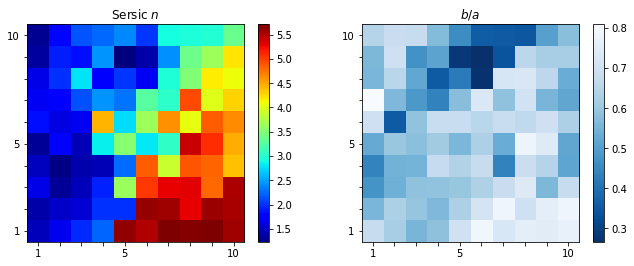

In [11]:
# DESOM 2 parameters

fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].set_title('Sersic $n$')
temp_panel = np.zeros(num_nodes)
ATTR = 'sersic_n'
for i in range(num_nodes):
    bmu_mask = (FP_table['bmu']==i)
    temp_panel[i] = np.mean(FP_table[bmu_mask][ATTR])
    
panel = ax[0].imshow(temp_panel.reshape(map_size),cmap='jet')
cbar = fig.colorbar(panel,ax=ax[0])
fix_ticks(ax[0])


ax[1].set_title('$b / a$')
temp_panel = np.zeros(num_nodes)
ATTR = 'b_over_a'
for i in range(num_nodes):
    bmu_mask = (FP_table['bmu']==i)
    temp_panel[i] = np.mean(FP_table[bmu_mask][ATTR])
    
panel = ax[1].imshow(temp_panel.reshape(map_size),cmap='Blues_r')
cbar = fig.colorbar(panel,ax=ax[1])
fix_ticks(ax[1])


In [12]:
''' better galaxy selection for imaging '''
# remove the top and bottom 25% of galaxies
# based on their age (to get an ifu more typical for the node)


# PART 1: GET AVERAGE AGES OF GALAXIES FOR EACH NODE
gal_in_node = list()
for i in range(num_nodes):
    mask = (FP_table['bmu']==i)
    finite_mask = (np.isfinite(FP_table[mask]['av_age']))
    gal_in_node.append(FP_table['av_age'][mask][finite_mask])


# PART 2: REMOVE OUTLIERS
better_each_node = list()
for i in range(num_nodes):
    bmu_mask = (FP_table['bmu'] == i)
    try:
        low_threshold =  np.percentile(gal_in_node[i],25)
        high_threshold = np.percentile(gal_in_node[i],75)
    
        low_mask =  (FP_table[bmu_mask]['av_age'] > low_threshold)
        high_mask = (FP_table[bmu_mask]['av_age'] < high_threshold)
        total_mask = low_mask * high_mask
        better_each_node.append(FP_table[bmu_mask][total_mask]['plateifu'][0])
    
    except:
        print('!',i,total_mask.sum())
        better_each_node.append('none')
        

# PART 3: SUCCESS !      
print(better_each_node)

['8601-12702', '8144-3701', '8144-12703', '7975-9101', '8084-12703', '8080-6103', '8717-6102', '8252-3701', '7975-6102', '8604-12703', '8247-12703', '8600-12705', '8078-12704', '8082-9102', '8618-3704', '9485-3701', '8080-12702', '8077-12705', '8139-6101', '7977-3702', '7977-3703', '9181-1902', '8618-9102', '8459-1901', '7815-12703', '8618-12701', '9485-6104', '8947-12703', '8603-12703', '8147-3704', '8247-12704', '8603-6103', '9029-1902', '8618-12703', '8312-6104', '9869-9102', '8486-6104', '8606-3702', '8078-1901', '8978-3703', '7972-6104', '8081-3703', '8486-6102', '8947-3701', '8149-1901', '8623-9102', '8249-1902', '9181-1901', '7977-1901', '8997-6101', '8549-3702', '9183-3703', '7815-12702', '8486-1901', '9869-12704', '8486-3703', '9029-3701', '8995-6102', '7972-1901', '9029-3702', '7815-9102', '8456-12704', '9181-6104', '8458-12704', '9031-12703', '8144-6103', '8139-6104', '7972-3702', '8155-3704', '8993-3703', '8618-1901', '7975-12705', '8147-9102', '8990-6104', '7972-12701', '8

/home/finnarch/jupyter_py3/lib/python3.6/site-packages/astropy/table/column.py:1152: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/home/finnarch/jupyter_py3/lib/python3.6/site-packages/astropy/table/column.py:1152: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [13]:
# select several spectra from a few nodes

def node2idx(some_node, mapsize=10):
    row = int(some_node // mapsize)
    column = int(some_node % mapsize)
    return (column+1, mapsize-row) #inversed row indexes

def idx2node(index, mapsize=10): #index should be a tuple
    column_offset = (mapsize-index[1]) * mapsize
    row_offset = index[0]-1
    return column_offset + row_offset



NODES = [(3,1), (6,1), (8,9)]

for node in NODES:
    mask = (FP_table['bmu'] == idx2node(node))

    results = list(FP_table[mask]['plateifu'])
    print('node',node, ' or node ',idx2node(node),',',len(results),'galaxies.')
    print(results[:12],'\n')


node (3, 1)  or node  92 , 53 galaxies.
['8606-9102', '8249-6102', '8991-9101', '8439-9102', '8941-3702', '8456-12702', '9185-6102', '7958-12701', '8996-6102', '9033-1901', '8604-9102', '8440-6102'] 

node (6, 1)  or node  95 , 55 galaxies.
['8717-9102', '8555-12701', '8991-6102', '8145-12702', '8946-6104', '9883-3702', '9883-6104', '8613-6102', '9085-6102', '8616-12703', '8309-6102', '9033-6104'] 

node (8, 9)  or node  17 , 62 galaxies.
['8077-12705', '7815-3704', '9183-3704', '8555-12705', '8550-6104', '8606-3701', '8999-6102', '8995-12705', '8144-6104', '8439-12705', '8940-9101', '8940-12702'] 

